In [84]:
import pandas as pd
import numpy as np
import zipfile
import re

from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.display import display, HTML
from string import Template
from IPython.display import Javascript
import json

from covariance_selection_algorithm import calculate

In [85]:
archive = zipfile.ZipFile('wine-quality.zip', 'r')
name = archive.namelist()

print(name)

['wineQualityReds.csv', 'wineQualityWhites.csv']


In [86]:
# выбираем данные для анализа

data = pd.read_csv(archive.open(name[1]))
data = data.drop(['Unnamed: 0'], axis=1)

print(data.columns)

Index(['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar',
       'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [87]:
data.columns = ['фиксированная кислотность', 'летучая кислотность', 'лимонная кислота', 
                'остаточный сахар', 'хлориды', 'свободный диоксид серы', 
                'общий диоксид серы', 'плотность',
                'pH', 'сульфаты', 'спирт', 'качество']

Для алгоритма Демпстера необходима матрица корреляций, поэтому вычислим ее и визуализируем:

In [88]:
X = spearmanr(data)

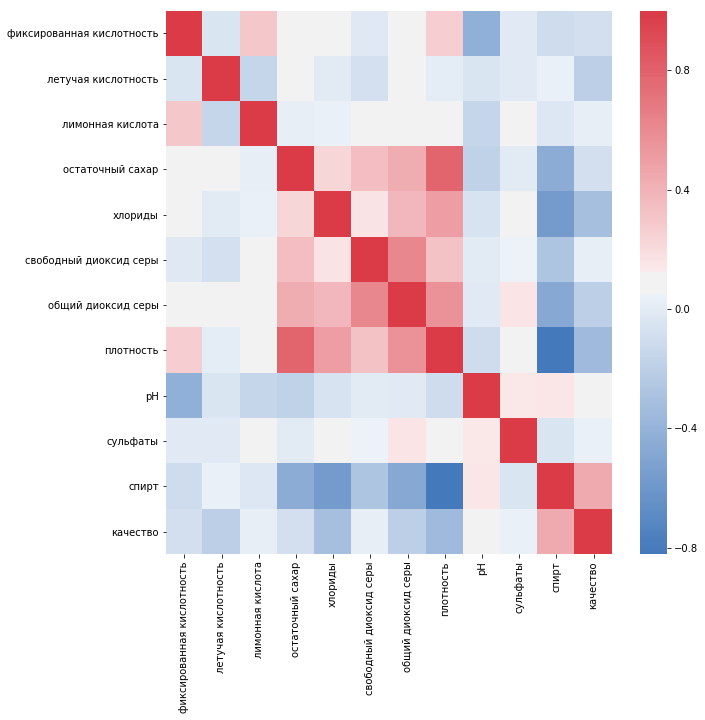

In [89]:
names = data.columns

plt.figure(figsize=(10, 10))

sns.heatmap(X[0], cmap=sns.diverging_palette(250, 10, as_cmap=True), 
            xticklabels=names, yticklabels=names)
plt.show()

На основании матрицы корреляций сделаем оценку для корреляционной матрицы:

In [90]:
cor_est = calculate(X[0], 0.5)

По оцененной корреляционной матрице вычислим обратную матрицу:

In [77]:
cor_inv = np.triu(np.linalg.inv(cor_est))

for i in range(cor_est.shape[0]):
    for j in range(cor_est.shape[0]):
        if np.round(cor_inv[i,j], 4) == 0:
            cor_est[i,j] = 0
        else:
            cor_est[i,j] = cor_est[i,j]    

По оцененной и обратной корреляционной матрице созадим граф: вершины графа - переменные, которые анализируем, ребра графа - оцененная связь между переменными.

In [78]:
# задаем ребра графа

edges = [] 

for i in range(cor_est.shape[0]):
    for j in range(cor_est.shape[0]):
        if abs(round(cor_est[i,j], 2)) > 0.2:
            if i!=j:
                item = {'from': i, 'to': j, 'weight': cor_est[i,j]}
                edges.append(item)

node = list(set([list(e.values())[0] for e in edges] + [list(e.values())[1] for e in edges]))

In [79]:
# задаем вершины графа

nodes = []

for i in range(len(node)):
    item = {'id': node[i], 'label': names[node[i]]}
    nodes.append(item)

In [83]:
# создаем граф и трансформируем его в JSON graph

g = {"nodes": nodes, "edges": edges}
jsonGraph = json.dumps(g, indent=4)

# Javascript
Javascript("""window.jsonGraph={};""".format(jsonGraph))

<IPython.core.display.Javascript object>

Далее много-много строк для визуализации полученного графа при помощи vis.js. Подробнее о том, как это делать, можно узнать здесь: https://www.codementor.io/isaib.cicourel/visjs-visualization-in-jupyter-notebook-phgb3fjv0

In [60]:
%%html
<div id="mynetwork"></div>

In [62]:
%%javascript
requirejs.config({
    paths: {
        vis: 'vis'
    }
});

require(['vis'], function(vis){
    
    var container = document.getElementById('mynetwork');
    var options = {
        width: '800px',
        height: '400px',
        layout: {hierarchical:{enabled:true,
        levelSeparation: 80,
        nodeSpacing: 100,
        treeSpacing: 200,}},
     };
    
    var graph = window.jsonGraph;
    
    var network = new vis.Network(container, graph, options);
});

<IPython.core.display.Javascript object>